In [2]:
from glob import glob
import pandas as pd
from tqdm.auto import tqdm

paths = glob("./bier_results/**/*.parquet")

df_list = []

for p in tqdm(paths):
    single_df = pd.read_parquet(p)
    df_list.append(pd.DataFrame(single_df.iloc[0].to_dict(),
             index=[(single_df.index[0], single_df.index[1])]
             ))
all_df = pd.concat(df_list).reset_index(drop=False)
all_df["dataset_name"] = all_df["index"].str[0]
all_df["model_name"] = all_df["index"].str[1]
metric_names = ['MAP', 'NDCG', 'P', 'Recall']
metrics_k_list = [1, 3, 5, 10, 100, 1000]

# for metric_name in metric_names:
#     grouped = all_df[
#         (all_df["model_name"] != "cross-encoder/ms-marco-electra-base") # Remove this because the results outlie so much lower that they detract from the graph
#     ].rename(
#         columns={f"{metric_name}@{k}": k for k in metrics_k_list}
#     ).groupby("model_name")[metrics_k_list].agg(['mean', 'std'])

#     # Extract mean and standard deviation
#     means = grouped.T.loc[[x[1] == "mean" for x in grouped.T.index]].reset_index(level=1, drop=True)
#     std = grouped.T.loc[[x[1] == "std" for x in grouped.T.index]].reset_index(level=1, drop=True)

#     # Plot with error bars
#     ax = means.plot(title=metric_name)

#     ax.set_xlabel("@")
#     ax.set_ylabel("Mean value (9 datasets)")
# all_df["Model name"] = all_df["model_name"].apply(lambda x: x.replace("/", "/\n"))
# ax = all_df[
#         (all_df["model_name"] != "cross-encoder/ms-marco-electra-base") # Remove this because the results outlie so much lower that they detract from the graph
#     ].boxplot(column="time", by="Model name", figsize=(8, 5))
# ax.set_ylabel("Inference time (s)")
# ax.set_xlabel("")
# ax.set_title("")
# ax.figure.suptitle("")
# metric_names = ['MAP', 'NDCG', 'P', 'Recall']
# metrics_k_list = [1, 3, 5, 10, 100, 1000]

all_df[["dataset_name", "model_name"] + [f"MAP@{k}" for k in metrics_k_list]]
# all_df[["dataset_name", "model_name"] + [f"Recall@{k}" for k in metrics_k_list]]
# all_df[["dataset_name", "model_name"] + [f"NDCG@{k}" for k in metrics_k_list]]
# all_df[["dataset_name", "model_name"] + [f"P@{k}" for k in metrics_k_list]]



  0%|          | 0/54 [00:00<?, ?it/s]

,dataset_name,model_name,MAP@1,MAP@3,MAP@5,MAP@10,MAP@100,MAP@1000
0,arguana,lightblue/lora_reranker_r8a16,0.35%,0.46%,0.49%,0.51%,0.51%,0.51%
1,dbpedia-entity,lightblue/lora_reranker_r8a16,0.05%,0.09%,0.11%,0.13%,0.18%,0.18%
2,fiqa,lightblue/lora_reranker_r8a16,0.19%,0.28%,0.31%,0.32%,0.33%,0.33%
3,nfcorpus,lightblue/lora_reranker_r8a16,0.06%,0.10%,0.12%,0.14%,0.16%,0.16%
4,scidocs,lightblue/lora_reranker_r8a16,0.04%,0.07%,0.08%,0.09%,0.11%,0.11%
5,scifact,lightblue/lora_reranker_r8a16,0.63%,0.70%,0.72%,0.72%,0.72%,0.72%
6,trec-covid-v2,lightblue/lora_reranker_r8a16,0.00%,0.01%,0.01%,0.02%,0.11%,0.11%
7,vihealthqa,lightblue/lora_reranker_r8a16,0.19%,0.22%,0.23%,0.24%,0.24%,0.24%
8,webis-touche2020,lightblue/lora_reranker_r8a16,0.03%,0.06%,0.08%,0.11%,0.20%,0.20%
9,arguana,lightblue/lb-reranker-0.5B-v1.0,0.26%,0.40%,0.43%,0.45%,0.46%,0.46%


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

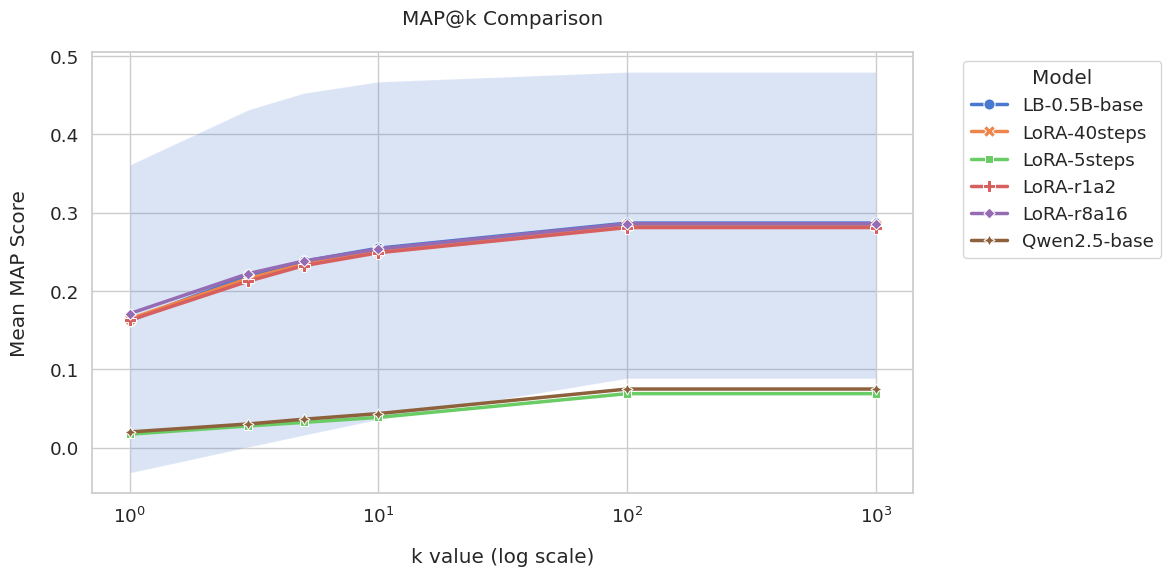

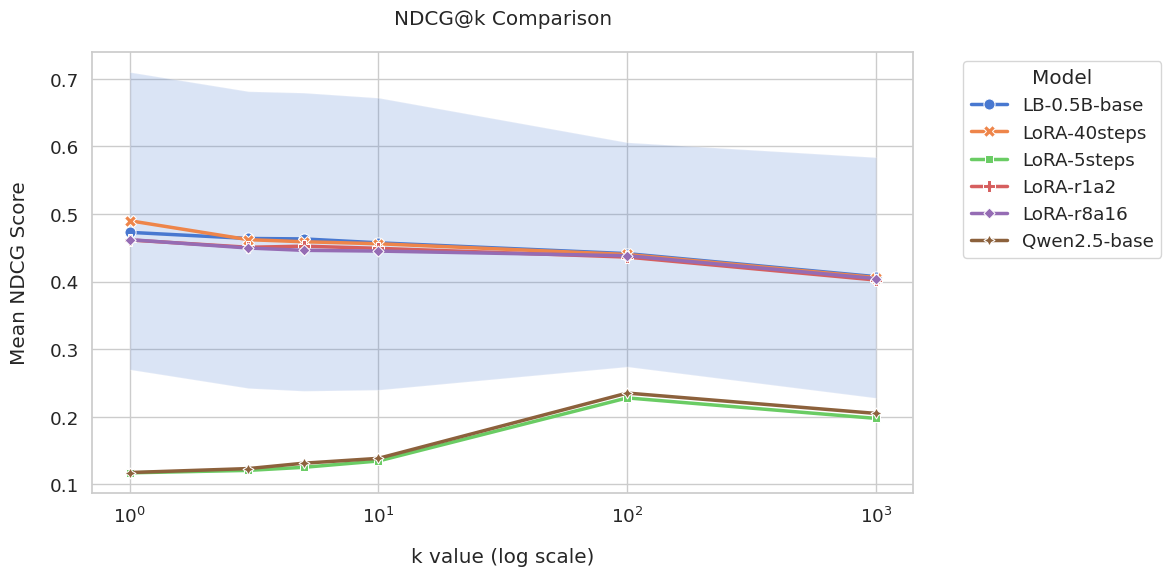

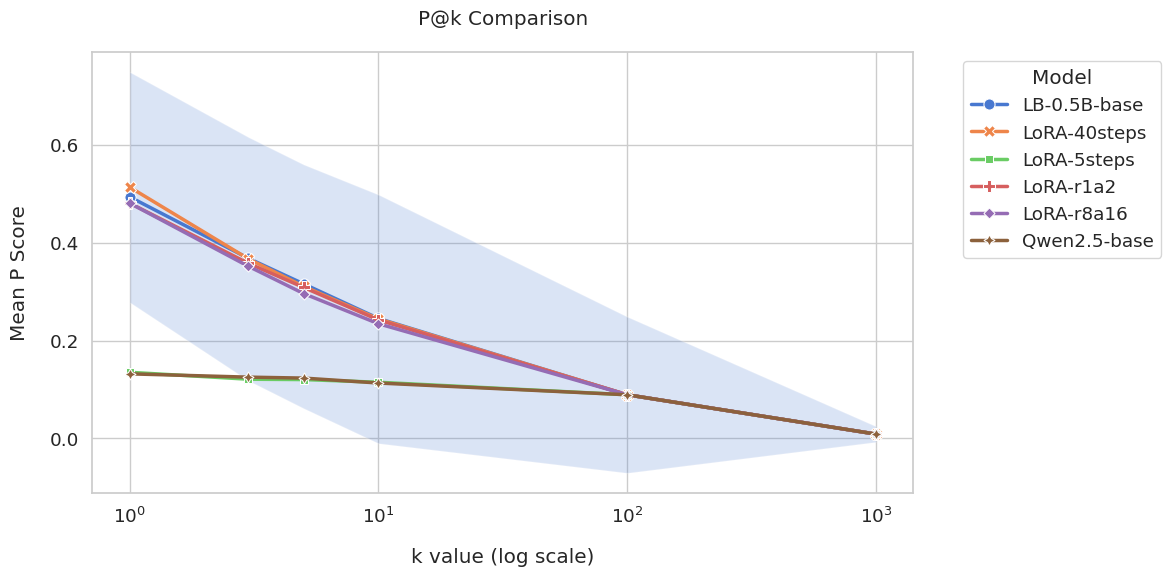

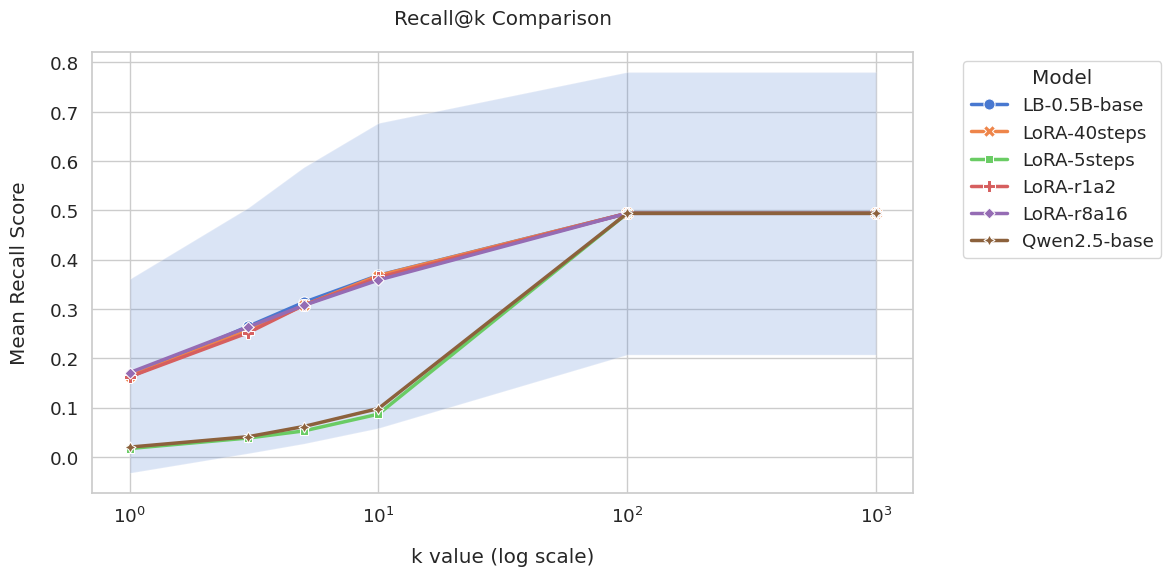

/tmp/ipykernel_252782/3268320700.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


ValueError: 'yerr' (shape: (6,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

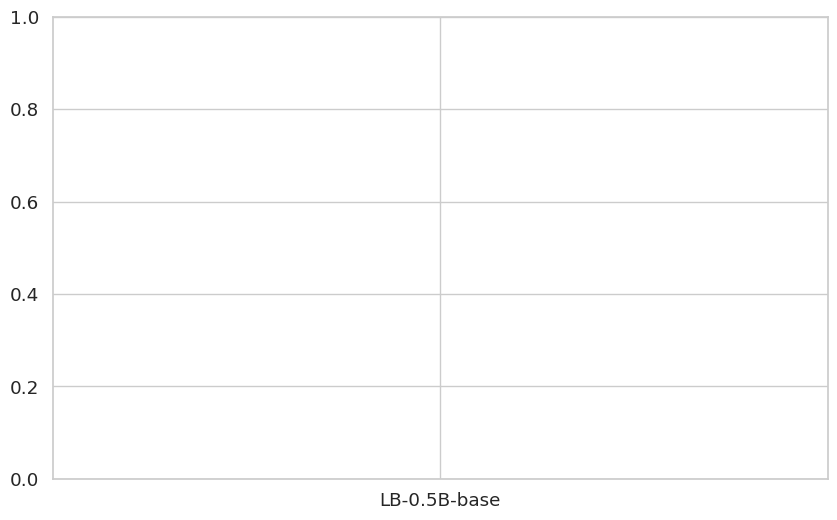

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.figure(figsize=(12, 8))

# 定义简化模型名称映射
model_name_map = {
    "lightblue/lora_reranker_r8a16": "LoRA-r8a16",
    "lightblue/lb-reranker-0.5B-v1.0": "LB-0.5B-base",
    "Qwen/Qwen2.5-0.5B-Instruct": "Qwen2.5-base",
    "loki_reranker_qwen2_5-0-5b-5": "LoRA-5steps",
    "loki_reranker_qwen2_5-0-5b-40": "LoRA-40steps",
    "lightblue/lora_reranker_r1a2": "LoRA-r1a2"
}

# 预处理数据
plot_df = all_df[all_df["model_name"].isin(model_name_map.keys())].copy()
plot_df["model"] = plot_df["model_name"].map(model_name_map)

# 1. 折线图：各模型MAP@k变化趋势
plt.figure(figsize=(12, 6))
for metric in ['MAP', 'NDCG', 'P', 'Recall']:
    plt.figure(figsize=(12, 6))
    metric_df = plot_df.melt(
        id_vars=["dataset_name", "model"],
        value_vars=[f"{metric}@{k}" for k in metrics_k_list],
        var_name="k",
        value_name="score"
    )
    metric_df["k"] = metric_df["k"].str.extract(r'@(\d+)').astype(int)
    
    # 计算均值与标准差
    agg_df = metric_df.groupby(["model", "k"])["score"].agg(['mean', 'std']).reset_index()
    
    # 绘制折线图
    sns.lineplot(
        data=agg_df,
        x="k",
        y="mean",
        hue="model",
        style="model",
        markers=True,
        dashes=False,
        markersize=8,
        linewidth=2.5
    )
    
    plt.fill_between(
        x=agg_df[agg_df["model"]=="LoRA-40steps"]["k"],
        y1=agg_df[agg_df["model"]=="LoRA-40steps"]["mean"] - agg_df[agg_df["model"]=="LoRA-40steps"]["std"],
        y2=agg_df[agg_df["model"]=="LoRA-40steps"]["mean"] + agg_df[agg_df["model"]=="LoRA-40steps"]["std"],
        alpha=0.2
    )
    
    plt.title(f"{metric}@k Comparison", pad=20)
    plt.xlabel("k value (log scale)", labelpad=15)
    plt.ylabel(f"Mean {metric} Score", labelpad=15)
    plt.xscale('log')
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 2. 柱状图：平均性能对比（k=10）
plt.figure(figsize=(10, 6))
k_selected = 10
metric = "MAP"

agg_df = plot_df.groupby("model")[f"{metric}@{k_selected}"].agg(['mean', 'std']).reset_index()
agg_df = agg_df.sort_values("mean", ascending=False)

sns.barplot(
    data=agg_df,
    x="model",
    y="mean",
    yerr=agg_df["std"],
    order=agg_df["model"],
    palette="viridis"
)

plt.title(f"Average {metric}@{k_selected} Comparison", pad=20)
plt.xlabel("Model", labelpad=15)
plt.ylabel(f"Mean {metric}@{k_selected}", labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. 箱线图：跨数据集表现分布
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=plot_df.melt(
        id_vars=["dataset_name", "model"],
        value_vars=[f"MAP@{k}" for k in [1, 5, 10]],
        var_name="metric",
        value_name="score"
    ),
    x="model",
    y="score",
    hue="metric",
    palette="Set2"
)

plt.title("Performance Distribution Across Datasets", pad=20)
plt.xlabel("Model", labelpad=15)
plt.ylabel("Score", labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_252782/3568577729.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
/tmp/ipykernel_252782/3568577729.py:66: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_252782/3568577729.py:66: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_252782/3568577729.py:66: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.pointplot(


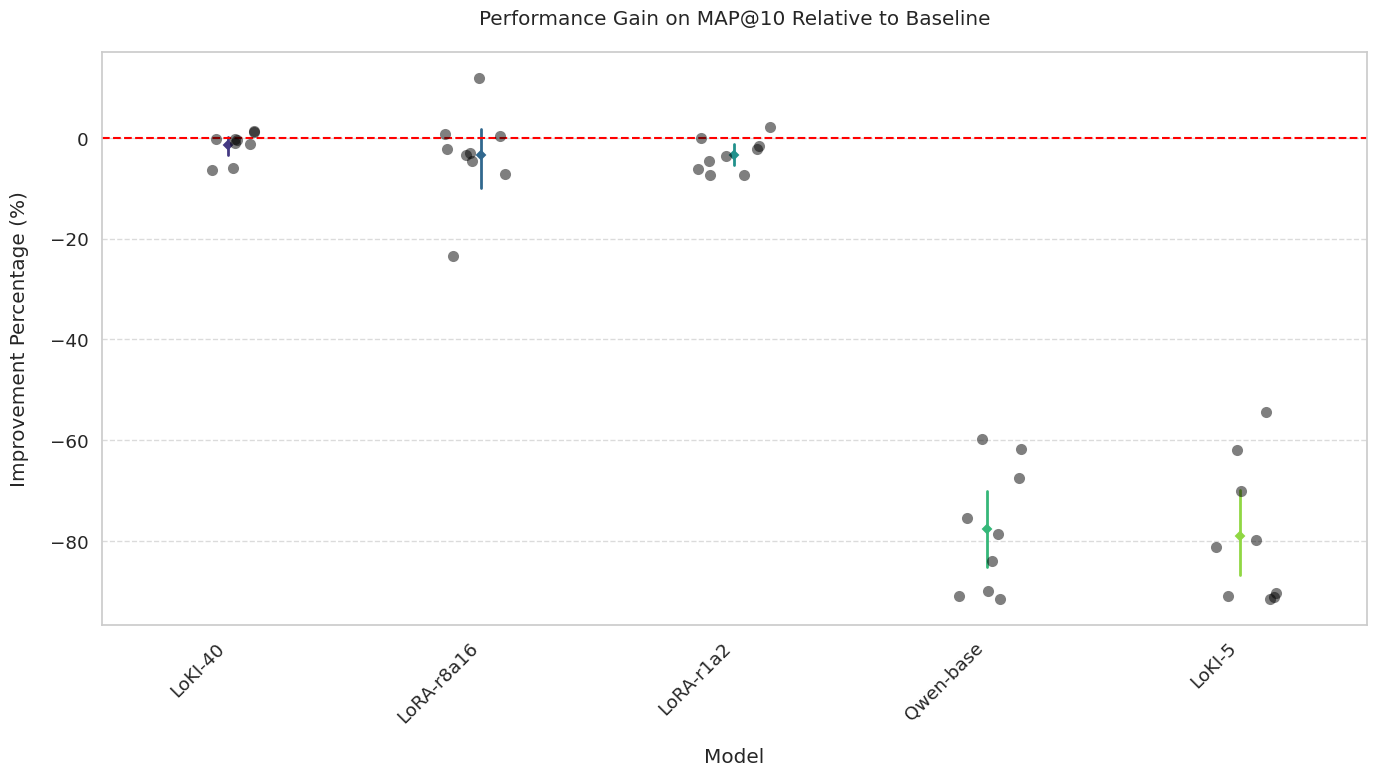

综合性能对比报告：


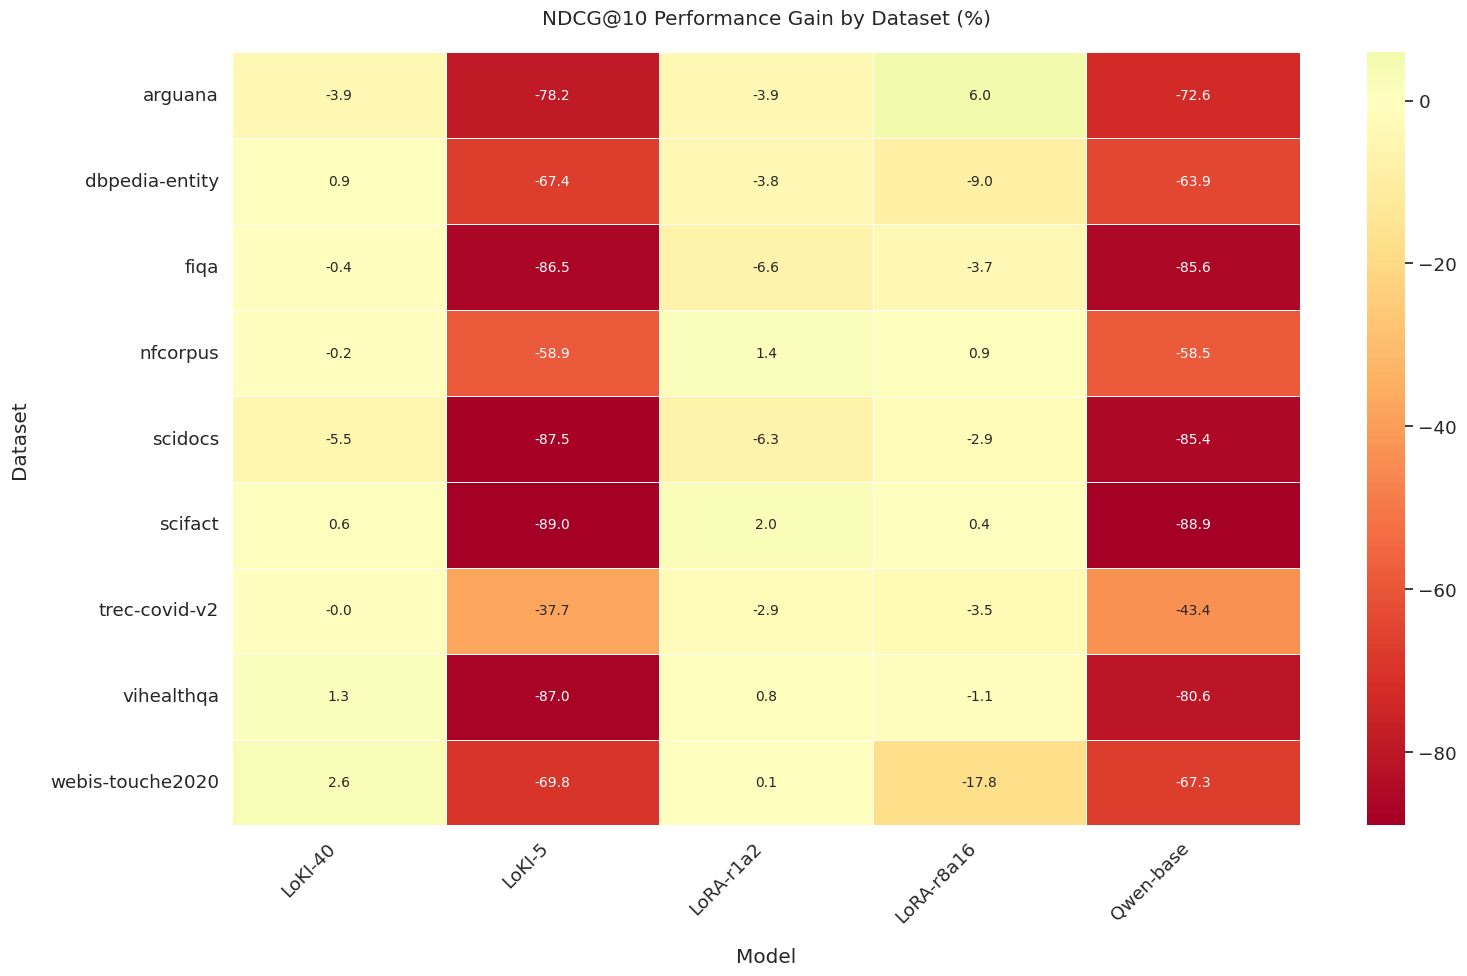

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 配置显示设置
pd.set_option('display.float_format', '{:.2f}%'.format)
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'DejaVu Sans'

# 定义基准模型
BASELINE_MODEL = "lightblue/lb-reranker-0.5B-v1.0"

# 模型名称映射
model_name_map = {
    "lightblue/lora_reranker_r8a16": "LoRA-r8a16",
    "lightblue/lb-reranker-0.5B-v1.0": "Baseline",
    "Qwen/Qwen2.5-0.5B-Instruct": "Qwen-base",
    "loki_reranker_qwen2_5-0-5b-5": "LoKI-5",
    "loki_reranker_qwen2_5-0-5b-40": "LoKI-40",
    "lightblue/lora_reranker_r1a2": "LoRA-r1a2"
}

# 数据预处理
def prepare_comparison_data(metric='MAP', k=10):
    # 提取目标指标列
    target_col = f"{metric}@{k}"
    baseline = all_df[all_df["model_name"] == BASELINE_MODEL][["dataset_name", target_col]]
    
    # 合并基准数据
    merged = all_df.merge(
        baseline, 
        on="dataset_name", 
        suffixes=('', '_baseline'),
        how='left'
    )
    
    # 计算相对百分比
    merged[f"{metric}_diff"] = (merged[target_col] / merged[f"{target_col}_baseline"] - 1) * 100
    merged["model"] = merged["model_name"].map(model_name_map)
    
    # 过滤有效数据
    return merged[merged["model"] != "Baseline"].dropna(subset=[f"{metric}_diff"])

# 生成对比矩阵
def generate_comparison_matrix(metric='MAP', k=10):
    df = prepare_comparison_data(metric, k)
    pivot_table = df.pivot_table(
        index='model',
        columns='dataset_name',
        values=f"{metric}_diff",
        aggfunc='mean'
    )
    return pivot_table.T  # 转置使模型作为列显示

# 可视化函数
def visualize_performance_gain(metric='MAP', k=10):
    df = prepare_comparison_data(metric, k)
    
    plt.figure(figsize=(14, 8))
    
    # 排序模型
    order = df.groupby('model')[f"{metric}_diff"].mean().sort_values(ascending=False).index
    
    # 绘制分布点线图
    sns.pointplot(
        data=df,
        x='model',
        y=f"{metric}_diff",
        order=order,
        join=False,
        scale=0.7,
        palette="viridis",
        errwidth=2,
        markers='D'
    )
    
    # 添加数据点
    sns.stripplot(
        data=df,
        x='model',
        y=f"{metric}_diff",
        order=order,
        color='black',
        alpha=0.5,
        size=8,
        jitter=0.15
    )
    
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
    plt.title(f"Performance Gain on {metric}@{k} Relative to Baseline", pad=20)
    plt.xlabel("Model", labelpad=15)
    plt.ylabel("Improvement Percentage (%)", labelpad=15)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 生成所有指标的对比报告
def generate_full_report(k=10):
    results = []
    
    for metric in ['MAP', 'NDCG', 'P', 'Recall']:
        df = prepare_comparison_data(metric, k)
        agg_df = df.groupby('model')[f"{metric}_diff"].agg(['mean', 'std', 'count'])
        agg_df['metric'] = f"{metric}@{k}"
        results.append(agg_df)
    
    full_report = pd.concat(results).reset_index()
    
    # 格式优化
    return full_report.pivot(
        index='model',
        columns='metric',
        values=['mean', 'std']
    ).style.background_gradient(
        cmap='RdYlGn', 
        axis=0,
        subset=pd.IndexSlice[:, pd.IndexSlice['mean', :]]
    ).format(
        "{:.1f}%", 
        subset=pd.IndexSlice[:, ['mean', 'std']]
    )

# 执行分析
if __name__ == "__main__":
    # 示例：MAP@10的可视化
    visualize_performance_gain(metric='MAP', k=10)
    
    # 生成完整对比报告（在Jupyter中显示最佳）
    print("综合性能对比报告：")
    display(generate_full_report(k=10))
    
    # 生成热力图矩阵
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        generate_comparison_matrix('NDCG', 10),
        annot=True,
        fmt=".1f",
        cmap="RdYlGn",
        center=0,
        linewidths=0.5,
        annot_kws={"size": 10}
    )
    plt.title("NDCG@10 Performance Gain by Dataset (%)", pad=20)
    plt.xlabel("Model", labelpad=15)
    plt.ylabel("Dataset", labelpad=15)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_154147/3568577729.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.pointplot(


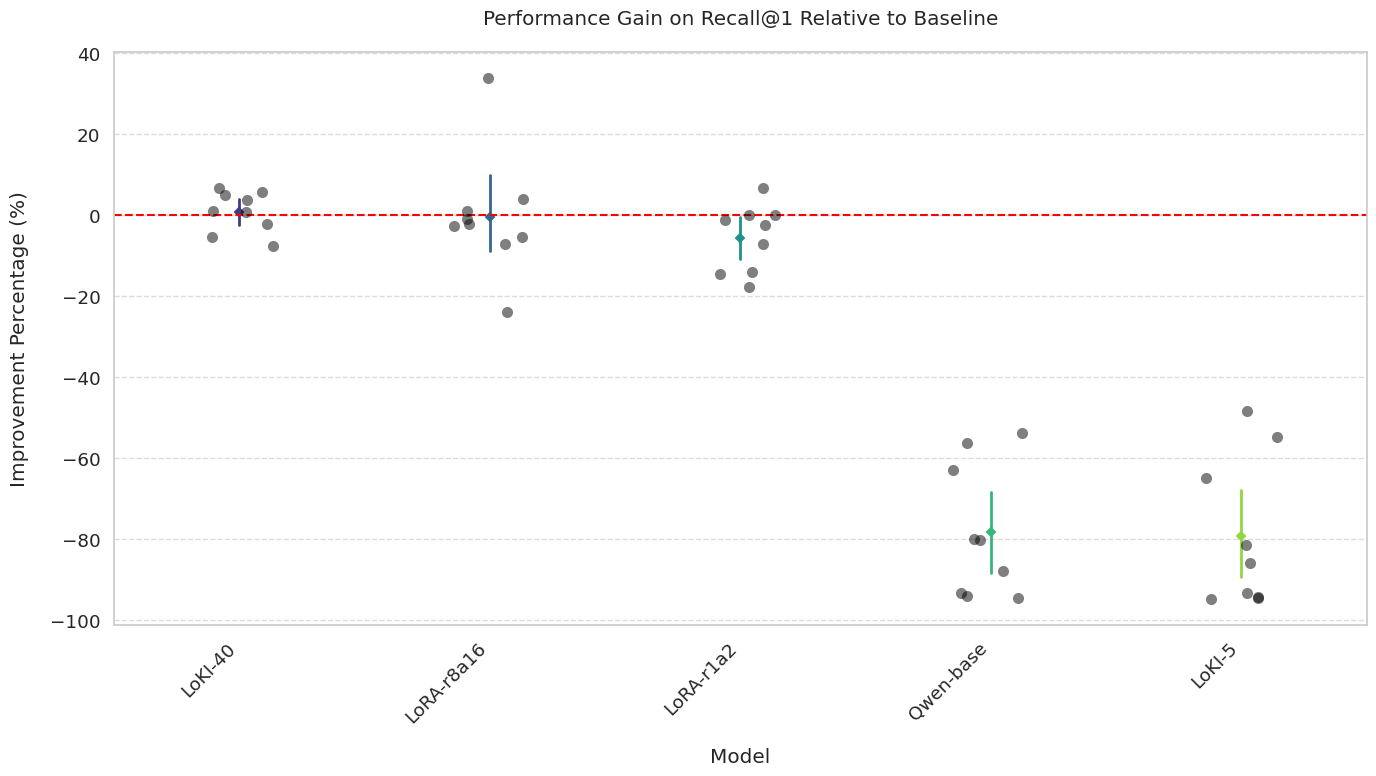

/tmp/ipykernel_154147/3568577729.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.pointplot(


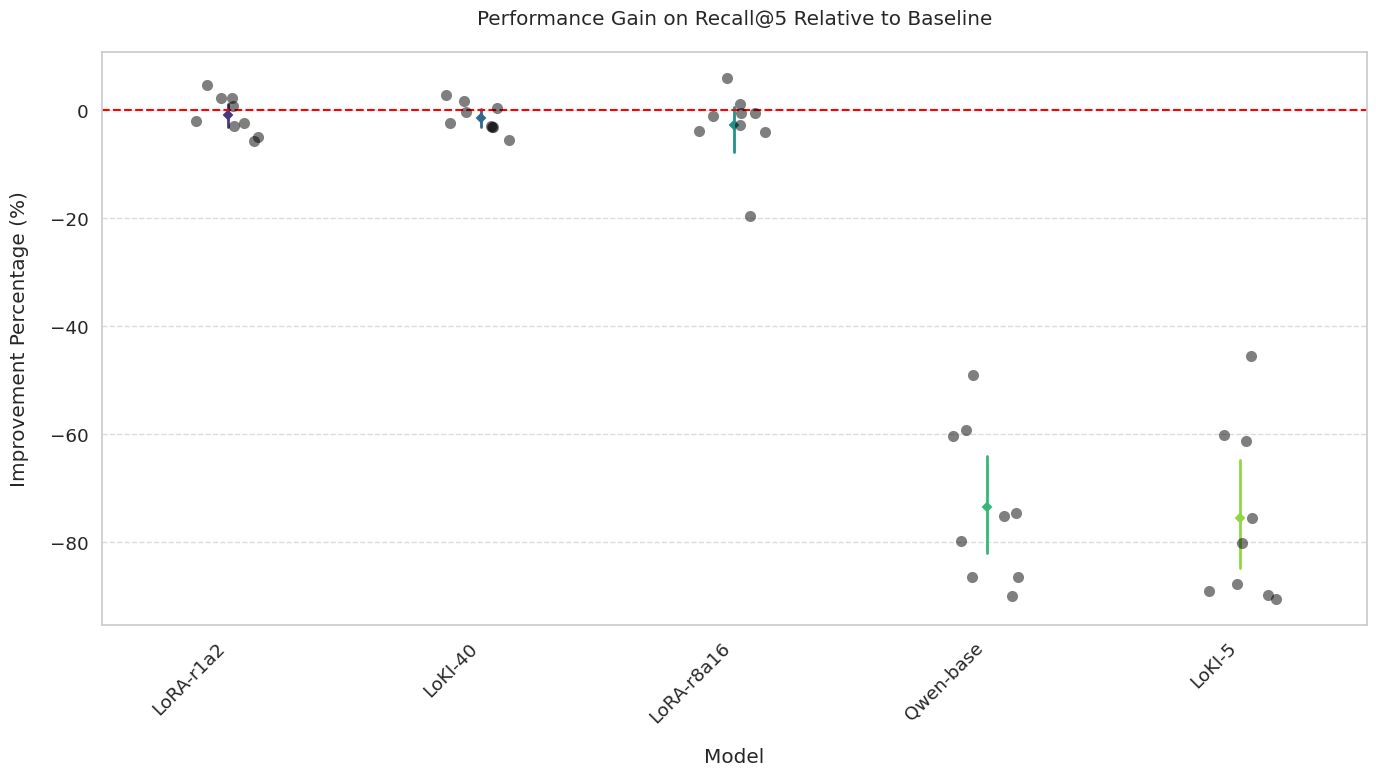

/tmp/ipykernel_154147/3568577729.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.pointplot(


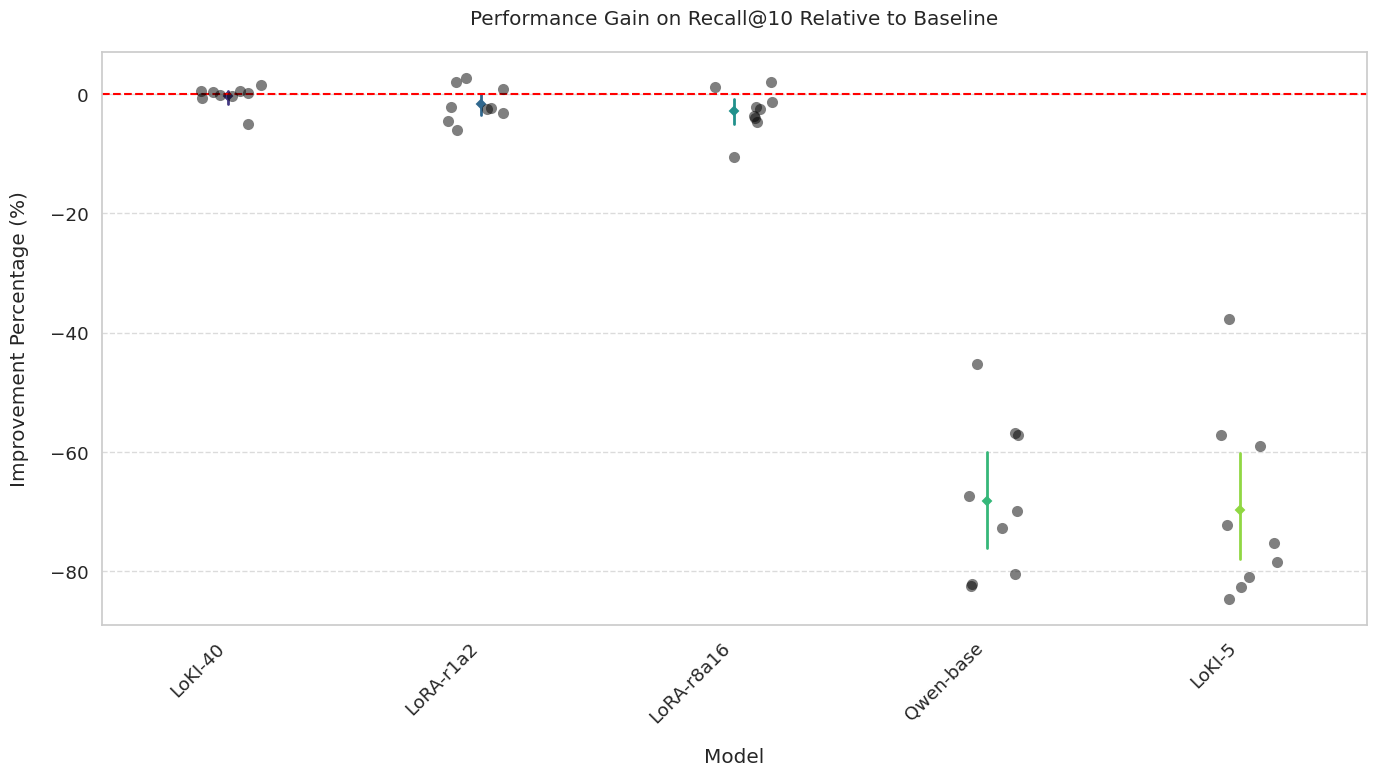

/tmp/ipykernel_154147/3568577729.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_154147/3568577729.py:66: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.pointplot(


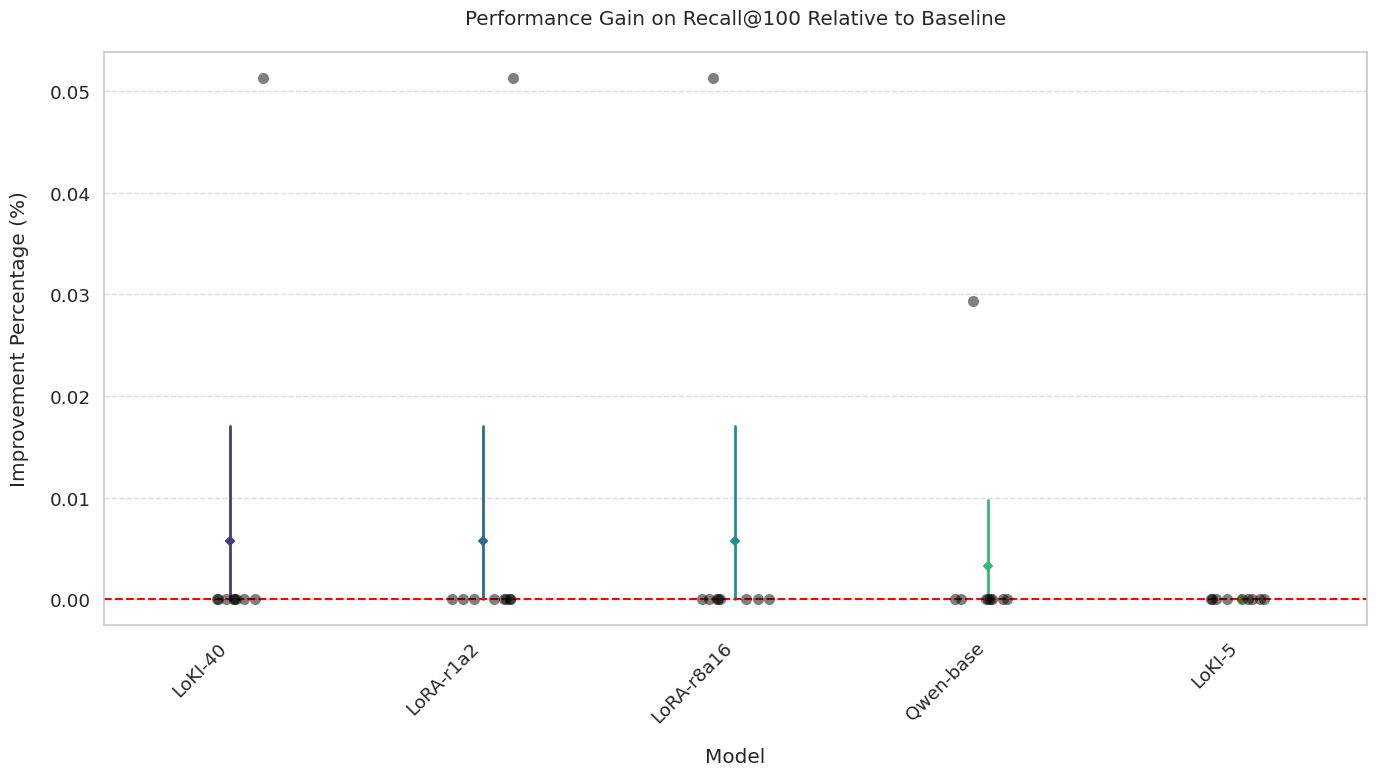

ValueError: Could not interpret value `metric_diff` for `y`. An entry with this name does not appear in `data`.

In [8]:
# 不同k值的对比分析
for k in [1, 5, 10, 100]:
    visualize_performance_gain('Recall', k)
    
# 跨指标综合分析
sns.relplot(
    data=pd.concat([prepare_comparison_data(m,10) for m in ['MAP','NDCG','P','Recall']]),
    x='model',
    y='metric_diff',
    hue='metric',
    kind='line',
    height=6,
    aspect=2.5
)